In [1]:
import io
import ipywidgets as widgets
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np
import urllib
from skimage.transform import resize
from matplotlib.image import imread
import os
from IPython.display import display
from skimage import io as io_url
import cv2
import numpy as np
from PIL import Image

In [6]:
# Create image widgets
image3_spatial = widgets.Image(format='png', width=500, height=500, description='Spatial')
image3_freq    = widgets.Image(format='png', width=500, height=500, description='Frequency')
sidebyside     = widgets.HBox([image3_spatial, image3_freq])

# Create slider/select widgets
slider_inner   = widgets.FloatSlider(value=0,      min=0, max=1,      step=0.01, description='Inner radius')
slider_outer   = widgets.FloatSlider(value=1.44/2, min=0, max=1.44/2, step=0.01, description='Outer radius')

buf            = io.BytesIO()

orig_img = io_url.imread('https://img2.zergnet.com/2309662_300.jpg')
orig_img = np.mean(orig_img, -1)

x = np.fft.fftfreq(orig_img.shape[0]);
y = np.fft.fftfreq(orig_img.shape[1]);

xv, yv = np.meshgrid(x, y)
xv = np.fft.fftshift(xv)
yv = np.fft.fftshift(yv)
def filter_frequency(orig_img, mask):
  """
  Remove frequency based on the given mask.
  Params:
    orig_img: numpy image
    mask: same shape with orig_img indicating which frequency to hold or remove
  Output:
    f_img: frequency image after applying mask
    img: image after applying mask
  """
  f_img = np.fft.fft2(orig_img)
  f_img_shifted = np.fft.fftshift(f_img)
  f_img_filtered = f_img_shifted * mask
  #shift back
  f_img_filtered_shifted = np.fft.ifftshift(f_img_filtered)
  #invert
  img = np.fft.ifft2(f_img_filtered_shifted)
  return np.abs(f_img_filtered), np.abs(img)

def on_value_change3(change):
    mask = (np.sqrt(xv**2 + yv**2) < slider_outer.value) & \
           (np.sqrt(xv**2 + yv**2) >= slider_inner.value)
    mask = np.float32(mask)
    # print(mask)
    fimg, img = filter_frequency(orig_img, mask)
    buf.seek(0)
    tmp = PIL.Image.fromarray(255*img/(img.max()+0.0001))
    tmp = tmp.convert('L')
    tmp.save(buf, 'png')
    image3_spatial.value = buf.getvalue()

    buf.seek(0)
    tmp = PIL.Image.fromarray(255*np.log(0.0001*fimg + 1))
    tmp = tmp.convert('L')
    tmp.save(buf, 'png')
    image3_freq.value = buf.getvalue()


slider_inner.observe(on_value_change3, names='value')
slider_outer.observe(on_value_change3, names='value')

on_value_change3(0)

display(sidebyside)
display(slider_inner)
display(slider_outer)

FloatSlider(value=0.0, description='Inner radius', max=1.0, step=0.01)

FloatSlider(value=0.72, description='Outer radius', max=0.72, step=0.01)

In [10]:
def show_img(img):
  plt.figure(figsize=(12, 9))
  plt.subplot(1, 2, 1)
  plt.imshow(img, cmap='gray')
  plt.title('Before')

In [7]:
def read_img(img_path, img_size=(512, 512)):
  """
    + Đọc ảnh
    + Chuyển thành grayscale
    + Thay đổi kích thước ảnh thành img_size
  """
  img = cv2.imread(img_path, 0)
  img = cv2.resize(img, img_size)
  return img


def create_hybrid_img(img1, img2, r):
  """
  Create hybrid image
  Params:
    img1: numpy image 1
    img2: numpy image 2
    r: radius that defines the filled circle of frequency of image 1. Refer to the homework title to know more.
  """
  # Apply Fourier Transform to both images
  f_img1 = np.fft.fftshift(np.fft.fft2(img1))
  f_img2 = np.fft.fftshift(np.fft.fft2(img2))

  # Create a mask based on the radius
  mask = np.zeros_like(img1)
  center_x, center_y = img1.shape[0] // 2, img1.shape[1] // 2
  for i in range(img1.shape[0]):
    for j in range(img1.shape[1]):
      if np.sqrt((i - center_x) ** 2 + (j - center_y) ** 2) < r:
        mask[i, j] = 1

  # Apply the mask to the frequency domain of image 1
  f_img1_filtered = f_img1 * mask

  # Combine the filtered frequency domain of image 1 and the frequency domain of image 2
  f_hybrid = f_img1_filtered + (1 - mask) * f_img2

  # Apply inverse Fourier Transform to obtain the hybrid image
  hybrid_img = np.abs(np.fft.ifft2(np.fft.ifftshift(f_hybrid)))

  return hybrid_img
  # You need to implement the function

(512, 512) (512, 512)


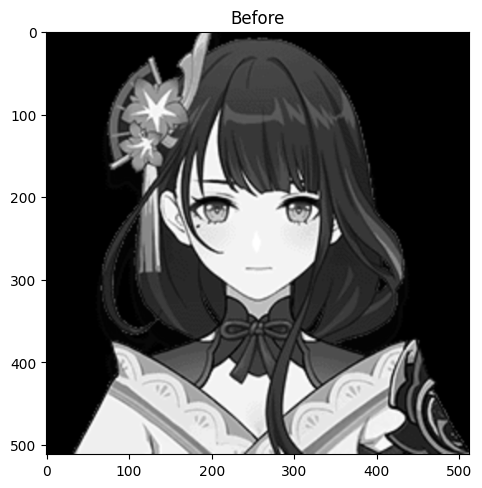

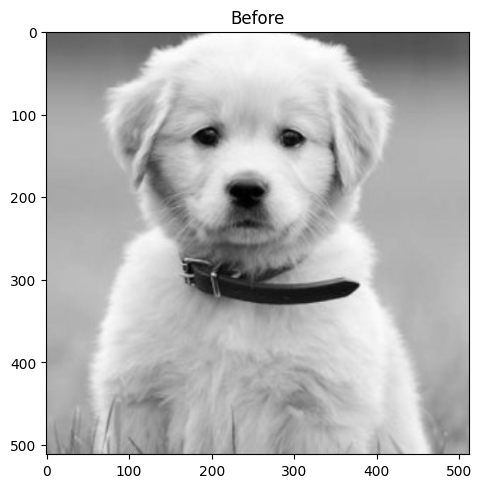

In [12]:
image_1_path = "image1.webp" # <-- need to change
image_2_path = "image2.jpg" # <-- need to change
img_1 = read_img(image_1_path)
img_2 = read_img(image_2_path)
show_img(img_1)
show_img(img_2)
print(img_1.shape, img_2.shape)

(-0.5, 511.5, 511.5, -0.5)

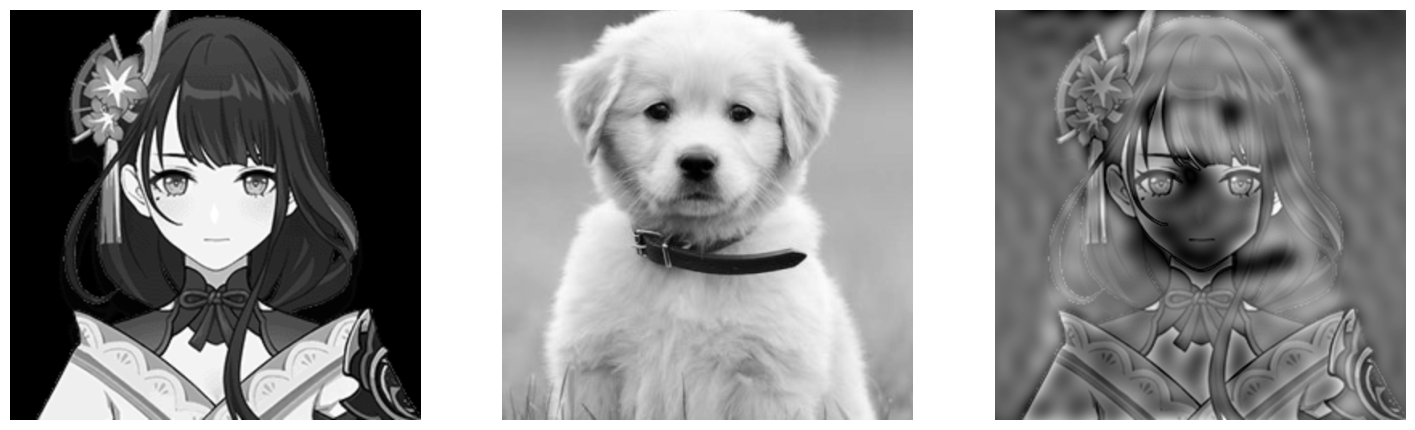

In [13]:

hybrid_img = create_hybrid_img(img_2, img_1, 14)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 15))
axes[0].imshow(img_1, cmap="gray")
axes[0].axis("off")
axes[1].imshow(img_2, cmap="gray")
axes[1].axis("off")
axes[2].imshow(hybrid_img, cmap="gray")
axes[2].axis("off")